In [247]:
%pylab inline
from scipy.stats import gaussian_kde
import tensorflow as tf
import pandas as pd
import simulate

def add_sequential_indices(dataframe, keymap=None):
    if keymap is None:
        keymap = {
            'IMAGENUMBER': 'IMAGEINDEX', 
            'PHINUMBER'  : 'PHIINDEX', 
            'RUN'        : 'RUNINDEX',
        }
    df = dataframe.reset_index()
    for key,newkey in keymap.items():
        df[newkey] = np.array(pd.DataFrame(np.sort(np.unique(df[key]))).reset_index().set_index(0).loc[df[key]])
    del df['level_0']
    return df

def pare_data(dataframe):
    """Remove reflection observations from which gammas cannot be estimated due to missing on or off reflections."""
    indexnames = dataframe.index.names
    df = dataframe.reset_index().set_index(['H', 'K', 'L', 'RUN', 'PHINUMBER'])
    df = df.loc[df[df.SERIES.str.contains('on')].index.intersection(df[df.SERIES.str.contains('off')].index)]
    if None not in indexnames:
        return df.reset_index().set_index(indexnames)
    else:
        return df.reset_index()

def image_metadata(dataframe, keys = None):
    """Aggregate the image metadata from an integration run into a separate dataframe"""
    if keys is None:
        keys = [k for k in dataframe.keys() if 'ipm' in k.lower()]
        specifically_check = ['Io', 'BEAMX', 'BEAMY', 'Icryst', 'SERIES', 'RUNINDEX']
        for k in specifically_check:
            if k in dataframe:
                keys.append(k)
    return dataframe[['IMAGEINDEX'] + list(keys)].groupby('IMAGEINDEX').mean()

def get_raw_gammas(dataframe):
    """Compute uncorrected intensity ratios, return (raw gamma array, indexing array)"""
    I = pare_data(dataframe)
    iobs        = I.pivot_table(values='IOBS', index=['H', 'K', 'L', 'RUNINDEX', 'PHIINDEX'], columns='SERIES', fill_value=np.NaN) 
    imagenumber = I.pivot_table(values='IMAGEINDEX', index=['H', 'K', 'L', 'RUNINDEX', 'PHIINDEX'], columns='SERIES', fill_value=-1)
    gammas = iobs[[i for i in iobs if 'on' in i]].sum(1) / iobs[[i for i in iobs if 'off' in i]].sum(1)
    return gammas, imagenumber


Populating the interactive namespace from numpy and matplotlib


/home/kevin/opt/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['gamma']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [321]:
#I = simulate.build_model("test/1ubq.pdb.hkl", "test/1ubq-flip.pdb.hkl", multiplicity = 2.0, missing=0.7)
I = pd.read_csv("test/1ubq_simulation.csv")

In [323]:
tf.reset_default_graph()

data = add_sequential_indices(pare_data(I))
gammas,imagenumber = get_raw_gammas(data)

#h is a dataframe that maps each h,k,l to a unique integer
h = gammas.reset_index()[['H','K','L']].drop_duplicates().reset_index(drop=True).reset_index().pivot_table(index=['H','K','L'], values='index')

gammaidx = h.loc[gammas.reset_index().set_index(['H', 'K', 'L']).index]

In [324]:
r = len(gammas.reset_index().groupby('RUNINDEX'))
M = image_metadata(data)
runidx = np.array(M['RUNINDEX'])

#We need two sparse tensors to map from Icryst estimates into the liklihood function. 
tmp = np.array(imagenumber)
idx = np.vstack((np.indices(tmp.shape)[0][tmp > 0], tmp[tmp > 0])).T
imageidx = tf.SparseTensor(idx, np.ones(len(idx), dtype=np.float32), (len(imagenumber), len(M)))
imageidx = tf.sparse_reorder(imageidx)

#Constants 
raw_gammas = tf.constant(np.float32(gammas))
ipm        = tf.constant(np.float32(M['Io']))
ipm_x      = tf.constant(np.float32(M['IPM_X']))
ipm_y      = tf.constant(np.float32(M['IPM_Y']))


In [325]:
#Regularization strength
rho = tf.placeholder(tf.float32)

#LCs for scaling IPM data
x_intercept   = tf.Variable(0.)
x_slope       = tf.Variable(1.)
y_intercept   = tf.Variable(0.)
y_slope       = tf.Variable(1.)
ipm_intercept = tf.Variable(0.)
ipm_slope     = tf.Variable(10.)

#Beam shape
sigx          = tf.Variable(10.)
sigy          = tf.Variable(10.)

#Crystal dimensions
xmin          = tf.Variable(-50.*np.ones(r, dtype=np.float32))
xmax          = tf.Variable( 50.*np.ones(r, dtype=np.float32))
ymin          = tf.Variable(-50.*np.ones(r, dtype=np.float32))
ymax          = tf.Variable( 50.*np.ones(r, dtype=np.float32))

#gammastimates
gamma         = tf.Variable(np.ones(len(h), dtype=np.float32))

beamx  = ipm_x * x_slope + x_intercept
beamy  = ipm_y * y_slope + y_intercept


In [326]:
Icryst = 0.25*(ipm_slope*ipm + ipm_intercept) * (
    tf.erf((tf.gather(xmin, runidx) - beamx)/sigx) - tf.erf((tf.gather(xmax, runidx) - beamx)/sigx)
    ) * (
    tf.erf((tf.gather(ymin, runidx) - beamy)/sigy) - tf.erf((tf.gather(ymax, runidx) - beamy)/sigy)
    )


In [327]:
absolute_deviation = (1./len(gammaidx))*tf.reduce_sum(tf.abs(tf.exp(tf.gather(gamma, gammaidx)) - raw_gammas * tf.sparse_tensor_dense_matmul(imageidx, tf.expand_dims(Icryst, 1))))
regularizer = (1./len(h))*tf.reduce_sum(tf.abs(gamma))

loss = (1. - rho)*absolute_deviation + rho*regularizer

In [328]:
"""
grads = tf.gradients(loss, [
          gamma,
    x_intercept,
        x_slope,
    y_intercept,
        y_slope,
  ipm_intercept,
      ipm_slope,
           sigx,
           sigy,
           xmin,
           xmax,
           ymin,
           ymax,
])"""

optimizer = tf.train.AdamOptimizer(0.1)
train_step = optimizer.minimize(loss)


nsteps = 20
cmap = plt.get_cmap()
norm = plt.Normalize(vmin=1., vmax=nsteps)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array((1., nsteps))

rhoval = .1

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(nsteps):
        _, loss_ = sess.run((train_step, loss),feed_dict={rho: rhoval})
        print(i,loss_)
        gamma_   = np.exp(sess.run(gamma, {rho: rhoval}))
        x1, x2 = gamma_.min(),gamma_.max()
        X = np.linspace(x1 - 0.1*(x2 - x1), x2 + 0.1*(x2 - x1), 200)
        plt.plot(X, gaussian_kde(gamma_)(X), c=sm.to_rgba(i+1))
        print(sess.run(xmin, {rho: rhoval}))
        print(sess.run(xmax, {rho: rhoval}))
        print(sess.run(ymin, {rho: rhoval}))
        print(sess.run(ymax, {rho: rhoval}))
        print(sess.run(ipm_slope, {rho: rhoval}))
        print(sess.run(ipm_intercept, {rho: rhoval}))
        

plt.colorbar(sm, ax=plt.gca())


ResourceExhaustedError: OOM when allocating tensor with shape[121567,121567] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[Node: mul_6 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Const, SparseTensorDenseMatMul/SparseTensorDenseMatMul)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'mul_6', defined at:
  File "/home/kevin/opt/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kevin/opt/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/kevin/opt/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/kevin/opt/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/kevin/opt/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 759, in _run_callback
    ret = callback()
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-327-521494758ca6>", line 1, in <module>
    absolute_deviation = (1./len(gammaidx))*tf.reduce_sum(tf.abs(tf.exp(tf.gather(gamma, gammaidx)) - raw_gammas * tf.sparse_tensor_dense_matmul(imageidx, tf.expand_dims(Icryst, 1))))
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 847, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1091, in _mul_dispatch
    return gen_math_ops.mul(x, y, name=name)
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 4759, in mul
    "Mul", x=x, y=y, name=name)
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3414, in create_op
    op_def=op_def)
  File "/home/kevin/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[121567,121567] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[Node: mul_6 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Const, SparseTensorDenseMatMul/SparseTensorDenseMatMul)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



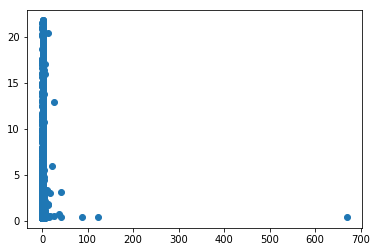

In [320]:
scatter(data.set_index(['H', 'K', 'L']).loc[h.index]['gamma'].drop_duplicates(), gamma_)